In [1]:
import pandas as pd
import numpy as np
import random
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# load the train data
file = open('train.txt', 'r')
lines = file.readlines()

# find unique author pairs and count the number of papers coauthored
from itertools import combinations
aPairs = {}
for line in lines:
    coAuthors = list(map(int, line.split()))
    for pair in combinations(coAuthors,2):
        pair = tuple(sorted(pair))
        if pair in aPairs:
            aPairs[pair] += 1
        else:
            aPairs[pair] = 1

# nca: the number of papers coauthored
# exist: whether the pair of authors has coauthored
ca = pd.DataFrame(list(aPairs.items()), columns=['Pair', 'nca'])
ca[['Source', 'Sink']] = pd.DataFrame(ca['Pair'].tolist(), index=ca.index)
ca['exist'] = pd.DataFrame([1]*(ca.shape[0]))
ca = ca[["Source", "Sink", "nca", "exist"]]

In [3]:
ca.head()

,Source,Sink,nca,exist
0,0,356,14,1
1,0,1236,14,1
2,356,1236,14,1
3,0,1655,9,1
4,0,1797,4,1


In [33]:
ca['nca'].sum()

29620

In [4]:
ca.shape

(16036, 4)

In [5]:
nodeL = np.union1d(ca['Source'].values, ca['Sink'].values)
nodeL

array([   0,    1,    2, ..., 4090, 4091, 4092])

In [6]:
len(nodeL)

3767

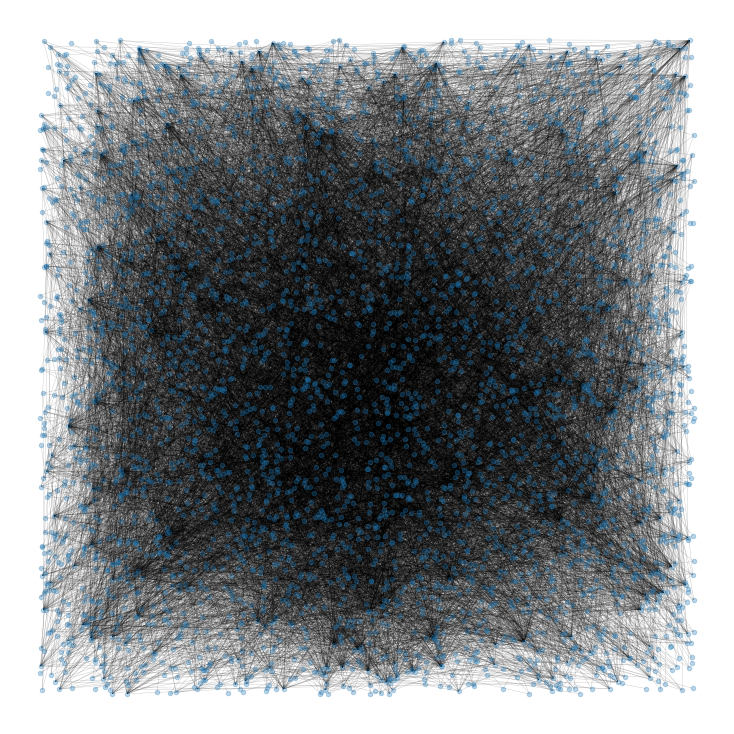

In [7]:
"""
The following code is adapted from:
https://www.analyticsvidhya.com/blog/2020/01/link-prediction-how-to-predict-your-future-connections-on-facebook/
"""

# create graph
G = nx.from_pandas_edgelist(ca, "Source", "Sink", create_using=nx.Graph())

# plot graph
plt.figure(figsize=(10,10))

pos = nx.random_layout(G, seed=23)
nx.draw(G, with_labels=False,  pos = pos, node_size = 20, alpha = 0.3, width = 0.3)

plt.show()

In [8]:
# build adjacency matrix
adj_G = nx.to_numpy_matrix(G, nodelist = nodeL)

# get unconnected node-pairs
all_unconnected_pairs = []

# traverse adjacency matrix
offset = 0
for i in tqdm(range(adj_G.shape[0])):
    for j in range(offset,adj_G.shape[1]):
        if i != j:
            if adj_G[i,j] == 0:
                all_unconnected_pairs.append([nodeL[i],nodeL[j]])
    offset = offset + 1

# df of non-exist edges
ne = pd.DataFrame([tuple(pair) for pair in all_unconnected_pairs], columns=['Source', 'Sink'])
ne['exist'] = pd.DataFrame([0]*(ne.shape[0]))
ne['nca'] = pd.DataFrame([0]*(ne.shape[0]))

100%|██████████| 3767/3767 [00:23<00:00, 161.84it/s]


In [9]:
ne.head()

,Source,Sink,exist,nca
0,0,1,0,0
1,0,2,0,0
2,0,3,0,0
3,0,4,0,0
4,0,5,0,0


In [10]:
ca = pd.concat([ca, ne])

In [11]:
ca.head()

,Source,Sink,nca,exist
0,0,356,14,1
1,0,1236,14,1
2,356,1236,14,1
3,0,1655,9,1
4,0,1797,4,1


In [12]:
# export dataframe to csv
# ca.to_csv("ca.csv")

In [13]:
ca["Pair"] = list(zip(ca.Source, ca.Sink))
ca = ca[["Pair", "Source", "Sink", "nca", "exist"]]
ca.head

<bound method NDFrame.head of                  Pair  Source  Sink  nca  exist
0            (0, 356)       0   356   14      1
1           (0, 1236)       0  1236   14      1
2         (356, 1236)     356  1236   14      1
3           (0, 1655)       0  1655    9      1
4           (0, 1797)       0  1797    4      1
...               ...     ...   ...  ...    ...
7077222  (4089, 4091)    4089  4091    0      0
7077223  (4089, 4092)    4089  4092    0      0
7077224  (4090, 4091)    4090  4091    0      0
7077225  (4090, 4092)    4090  4092    0      0
7077226  (4091, 4092)    4091  4092    0      0

[7093263 rows x 5 columns]>

In [14]:
cnL = []
for u,v in tqdm(ca.Pair):
    cn = sorted(nx.common_neighbors(G,u,v))
    cnL.append(((u,v), len(cn)))
cnDF = pd.DataFrame(cnL, columns=["Pair", "cn"])

100%|██████████| 7093263/7093263 [03:03<00:00, 38647.55it/s]


In [15]:
aa_index = nx.adamic_adar_index(G, ca.Pair)
aaDF = pd.DataFrame([((u,v),p) for u,v,p in aa_index], columns=["Pair", "aa_index"])

In [16]:
ra_index = nx.resource_allocation_index(G, ca.Pair)
raDF = pd.DataFrame([((u,v),p) for u,v,p in ra_index], columns=["Pair", "ra_index"])

In [17]:
ca = ca.join(cnDF.set_index('Pair'), on="Pair")
ca = ca.join(aaDF.set_index('Pair'), on="Pair")
ca = ca.join(raDF.set_index('Pair'), on="Pair")
ca.head()

,Pair,Source,Sink,nca,exist,cn,aa_index,ra_index
0,"(0, 356)",0,356,14,1,7,2.899858,0.628968
1,"(0, 1236)",0,1236,14,1,6,2.471649,0.531746
2,"(356, 1236)",356,1236,14,1,7,2.812086,0.587302
3,"(0, 1655)",0,1655,9,1,7,2.976054,0.668651
4,"(0, 1797)",0,1797,4,1,7,2.899858,0.628968


# Weak ties

In [18]:
# create weight dictionary
weight = ca[["Pair", "nca"]]
weightDict = pd.Series(weight.nca.values,index=weight.Pair).to_dict()

In [19]:
# add nca as weight to all edges
nx.set_edge_attributes(G, values = weightDict, name = 'weight')

In [20]:
# calculate WCN
def wcn(G, u, v, alpha):
    wcn = 0
    cnlist = list(sorted(nx.common_neighbors(G,u,v)))
    if len(cnlist) == 0:
        return wcn
    else:
        for cn in cnlist:
            wcn += ((G[u][cn]['weight'])**alpha) + ((G[v][cn]['weight'])**alpha)
        return wcn

In [21]:
wcn(G, 0, 356, 0.6)

44.2470898011236

In [22]:
# calculate WAA
def waa(G, u, v, alpha):
    waa = 0
    cnlist = list(sorted(nx.common_neighbors(G,u,v)))
    if len(cnlist) == 0:
        return waa
    else:
        for cn in cnlist:
            w = ((G[u][cn]['weight'])**alpha) + ((G[v][cn]['weight'])**alpha)
            cn_neighbors = list(sorted(G.neighbors(cn)))
            s = 0
            for ne in cn_neighbors:
                s += ((G[cn][ne]['weight'])**alpha)
            waa += w/(np.log(1+s))
        return waa

In [23]:
waa(G, 0, 356, 0.6)

12.77311102158459

In [24]:
# calculate WRA
def wra(G, u, v, alpha):
    wra = 0
    cnlist = list(sorted(nx.common_neighbors(G,u,v)))
    if len(cnlist) == 0:
        return wra
    else:
        for cn in cnlist:
            w = ((G[u][cn]['weight'])**alpha) + ((G[v][cn]['weight'])**alpha)
            cn_neighbors = list(sorted(G.neighbors(cn)))
            s = 0
            for ne in cn_neighbors:
                s += ((G[cn][ne]['weight'])**alpha)
            wra += w/s
        return wra

In [25]:
wra(G, 0, 356, 0.6)

1.4468961901525572

In [34]:
# set alpha
alpha = 0.9

In [35]:
WCN = []
for u,v in tqdm(ca.Pair):
    cnlist = sorted(nx.common_neighbors(G,u,v))
    value = wcn(G, u, v, alpha)
    WCN.append(((u,v), value))
wcnDF = pd.DataFrame(WCN, columns=["Pair", "WCN"])

100%|██████████| 7093263/7093263 [05:44<00:00, 20588.12it/s]


In [36]:
WAA = []
for u,v in tqdm(ca.Pair):
    cnlist = sorted(nx.common_neighbors(G,u,v))
    value = waa(G, u, v, alpha)
    WAA.append(((u,v), value))
waaDF = pd.DataFrame(WAA, columns=["Pair", "WAA"])

100%|██████████| 7093263/7093263 [05:30<00:00, 21459.77it/s]


In [37]:
WRA = []
for u,v in tqdm(ca.Pair):
    cnlist = sorted(nx.common_neighbors(G,u,v))
    value = wra(G, u, v, alpha)
    WRA.append(((u,v), value))
wraDF = pd.DataFrame(WRA, columns=["Pair", "WRA"])

100%|██████████| 7093263/7093263 [05:27<00:00, 21673.97it/s]


In [38]:
weak_ties = wcnDF.join(waaDF.set_index('Pair'), on="Pair")
weak_ties = weak_ties.join(wraDF.set_index('Pair'), on="Pair")
weak_ties.head()

,Pair,WCN,WAA,WRA
0,"(0, 356)",83.041696,20.598592,1.522746
1,"(0, 1236)",75.798683,18.822305,1.384504
2,"(356, 1236)",87.009568,21.650570,1.604475
3,"(0, 1655)",88.275209,22.088079,1.682613
4,"(0, 1797)",81.098878,20.322190,1.561990


In [39]:
weak_ties

,Pair,WCN,WAA,WRA
0,"(0, 356)",83.041696,20.598592,1.522746
1,"(0, 1236)",75.798683,18.822305,1.384504
2,"(356, 1236)",87.009568,21.650570,1.604475
3,"(0, 1655)",88.275209,22.088079,1.682613
4,"(0, 1797)",81.098878,20.322190,1.561990
...,...,...,...,...
7093258,"(4089, 4091)",0.000000,0.000000,0.000000
7093259,"(4089, 4092)",0.000000,0.000000,0.000000
7093260,"(4090, 4091)",0.000000,0.000000,0.000000
7093261,"(4090, 4092)",0.000000,0.000000,0.000000


In [40]:
# export dataframe to csv
weak_ties.to_csv("weak_ties.csv")